# Model Simulations
This notebook contains code to conduct numerical simualtions for ...

In [1]:
using Pkg

Pkg.activate("../")

using DiffEqBase, OrdinaryDiffEq, Plots
using Random, StatsBase, DelimitedFiles, Distributions
using SymPy, LinearAlgebra, GLM
using LaTeXStrings
using Combinatorics



  Activating environment at `~/Projects/Submitted/TemperatureAmplification/Project.toml`
┌ Info: Precompiling DiffEqBase [2b5f629d-d688-5b77-993f-72d75c75574e]
└ @ Base loading.jl:1342
┌ Info: Precompiling OrdinaryDiffEq [1dea7af3-3e70-54e6-95c3-0bf5283fa5ed]
└ @ Base loading.jl:1342
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1342
┌ Info: Precompiling GLM [38e38edf-8417-5370-95a0-9cbb8c7f171a]
└ @ Base loading.jl:1342


In [2]:
include("./scripts/GLV.jl")

E_R_eco (generic function with 1 method)

# Analyitical Approximations
First we look to see what the expected effect of interactions is in the exponential phase. To do so we can take a taylor series of the $\log(C)$ around $t = 0$. This gives an expression for the biomass of species $i$ at some small value of $t$ as:

\begin{align}
    \log(C_i(t)) &\approx \log(C_i(0)) +
                    +  t \frac{d \log(C_i(0))}{d t}
                    + \frac{t^2}{2} \frac{d^2 \log(C_i(0))}{d t^2}
\end{align}



Using the correct definitions we use 'SymPy' to give the approximation in terms of the parameters in the system:

In [3]:
#define symbols
aii, ua   = symbols("a_ii,μ_a")
t,T,N = symbols("t,T,N")

#Time dependent variables
C,uC,sC,x = symbols("C,μ_C,σ_C,x")
C = SymPy.Function(C)(t)
uC = SymPy.Function(uC)(t)
sC = SymPy.Function(sC)(t)

#Temp dependent variables
r, ur, sr = symbols("r, μ_r, sigma_r")
r = SymPy.Function(r)(T)
ur = SymPy.Function(ur)(T)
sr = SymPy.Function(sr)(T) 

#non time/temp dependent variables for lambdify
r_ , ur_, sr_ = symbols("r, μ_r,sigma_r")
C0,uC0,sC0 = symbols("C_0,μ_{C_0},σ_{C_0}")
ua_ = symbols("u_a");

First we set up the approximations of biomass

In [4]:
#get series
C_app = C.series(t,0,3).removeO()
logC_app = log(C).series(t,0,3).removeO()

   ⎛⎛  2      ⎞│                     ⎞                               
   ⎜⎜ d       ⎟│                    2⎟                               
   ⎜⎜───(C(ξ))⎟│      ⎛d       ⎞│    ⎟     ⎛d       ⎞│               
   ⎜⎜  2      ⎟│      ⎜──(C(ξ))⎟│    ⎟   t⋅⎜──(C(ξ))⎟│               
 2 ⎜⎝dξ       ⎠│ξ=0   ⎝dξ      ⎠│ξ=0 ⎟     ⎝dξ      ⎠│ξ=0            
t ⋅⎜─────────────── - ───────────────⎟ + ──────────────── + log(C(0))
   ⎜     2⋅C(0)              2       ⎟         C(0)                  
   ⎝                      2⋅C (0)    ⎠                               

Next we define the acutal equation for biomass growth $\frac{dC_i(t)}{dt}$ and the second time derivative $\frac{\delta^2 C_i(t)}{dt^2}$

In [5]:
#define dC system
dC = C*(r - (aii * C) + ua*uC)

#get second order derivative
dC2_1 = dC.diff(t)

⎛      d             d         ⎞                                       d      
⎜- aᵢᵢ⋅──(C(t)) + μₐ⋅──(μ_C(t))⎟⋅C(t) + (-aᵢᵢ⋅C(t) + μₐ⋅μ_C(t) + r(T))⋅──(C(t)
⎝      dt            dt        ⎠                                       dt     

 
)
 

From this we can see we need an equation for the derivative of the average biomass $\mu_C$ with respect to time. We approaximate this using a logistic growth equation with growth rate equal to the average growth rate across the community and a carrying capcity set by the solution of the mean-field approximation. We actualy use an exponential approximation of the logistic growth as we want to focus on the intial stages of communtiy assembly. 

In [6]:
#solve for K
uK = solve(solve(dC.args[1],C)[1].subs(r,ur) - uC, uC)[1]
duK = uK.diff(T)

d        
──(μᵣ(T))
dT       
─────────
 aᵢᵢ - μₐ

In [7]:
#derivative
# K = symbols("K")
# K = Function(K)(T)
# duC = (uC * ur * (1 - (uC / K)))
duC = uC * (ur - aii * uC - ua * uC)

(-aᵢᵢ⋅μ_C(t) - μₐ⋅μ_C(t) + μᵣ(T))⋅μ_C(t)

Next we substitue these expressions into the second derivative

In [8]:
#now substitute these terms to get dC2
dC2 = dC2_1.subs(C.diff(t),dC).subs(uC.diff(t),duC)

                                                                              
(-aᵢᵢ⋅(-aᵢᵢ⋅C(t) + μₐ⋅μ_C(t) + r(T))⋅C(t) + μₐ⋅(-aᵢᵢ⋅μ_C(t) - μₐ⋅μ_C(t) + μᵣ(T

                                                2     
))⋅μ_C(t))⋅C(t) + (-aᵢᵢ⋅C(t) + μₐ⋅μ_C(t) + r(T)) ⋅C(t)

And finally substitute these into the main approximation equations above

In [9]:
#params to sub
dC_sub = logC_app.args[1].args[2].args[2].args[3].args[1]
dC2_sub = logC_app.args[1].args[2].args[1].args[3]

#sub into the approximation
log_C_sol = logC_app.subs(dC_sub,dC.subs(t,0)).subs(dC2_sub,dC2.subs(t,0))

   ⎛                                                                          
 2 ⎜(-aᵢᵢ⋅(-aᵢᵢ⋅C(0) + μₐ⋅μ_C(0) + r(T))⋅C(0) + μₐ⋅(-aᵢᵢ⋅μ_C(0) - μₐ⋅μ_C(0) + 
t ⋅⎜──────────────────────────────────────────────────────────────────────────
   ⎝                                                               2⋅C(0)     

                                                    2                         
μᵣ(T))⋅μ_C(0))⋅C(0) + (-aᵢᵢ⋅C(0) + μₐ⋅μ_C(0) + r(T)) ⋅C(0)   (-aᵢᵢ⋅C(0) + μₐ⋅μ
────────────────────────────────────────────────────────── - ─────────────────
                                                                            2 

             2⎞                                               
_C(0) + r(T)) ⎟                                               
──────────────⎟ + t⋅(-aᵢᵢ⋅C(0) + μₐ⋅μ_C(0) + r(T)) + log(C(0))
              ⎠                                               

we use lambdify to get let us use this expression as a function 

In [10]:
#lambdify
#sub dependent vars
into = [r,ur,ua,C.subs(t,0),uC.subs(t,0),sC.subs(t,0)]
outo = [r_,ur_,ua_,C0,uC0,sC0]

final_log_C_sol = subs(log_C_sol,zip(into,outo)...) 

#lambdify parameter order -> (C0 aii r t ua ur uC0)
C_log_func = lambdify(final_log_C_sol)

#116 (generic function with 1 method)

And also calculate the $E_C$ value by taking the derivative of log biomass with respect to temperature

In [11]:
#Temperature dependence
x,y = symbols("x,y")

into = [r,ur,ua,C.subs(t,0),uC.subs(t,0),sC.subs(t,0)]
outo = [r_,ur_,ua_,C0,uC0,sC0]

E_C = log_C_sol.diff(T).expand().collect(ua)
E_C_final = subs(E_C,zip(into,outo)...)

          2 d        2            d               
  C₀⋅aᵢᵢ⋅t ⋅──(r)   t ⋅uₐ⋅μ_{C_0}⋅──(μᵣ)          
            dT                    dT         d    
- ─────────────── + ──────────────────── + t⋅──(r)
         2                   2               dT   

Which we can see is a funciton of the average interaction strength in the system $\mu_a$. Note $\mu_a$ only occurs as a product of the $t^2$ term showing that in the early stages of community assembly (when $t > t^2$) we expect there to be little effect of interacitons, but as $t$ grows, its effect will increase. We also lambdify this expression. 

In [12]:
#lambdify
dr_sub = E_C_final.args[1].args[2]
dur_sub = E_C_final.args[2].args[5]

E_C_final_2 = E_C_final.subs(dr_sub, x).subs(dur_sub, y)

# lambdify parameter order -> (C0 N aii t ua dr dur uc)
E_func = lambdify(E_C_final_2)

#116 (generic function with 1 method)

#### Temperature

Next we look at how the analytical approximation predicts respiration will change over temperature. 

first we look at the quality of the apporoximation across a temperature gradient for a single communtiy

In [13]:
Random.seed!(42)

#Number of species
Nsp = 50 

#Interactions
ua_vec = [-10,0,10]
a = [ x/(Nsp-1) .+ randn(Nsp,Nsp)./Nsp for x = ua_vec]
[a[i][j,j] = -10 for i = eachindex(a), j = 1:Nsp]
aii = -10

#growth rate
R = fill(1.0,Nsp) .+ randn(Nsp)./10
r = fill(1.0,Nsp) .+ randn(Nsp)./10

#params object
p = params.(Ref(r),Ref(R),a,Nsp)


C0 = fill(0.01, Nsp)
uC0 = mean(C0)
tspan = (0.0,3.0)
tsave = tspan[1]:0.01:tspan[2]

# const k =  8.617e-5
kT(Temp) = 1 / (8.617e-5 * (Temp+273.15))

function boltz(B0,E,ΔT)
    B0 * exp(-E * ΔT )
end

function dboltz(B0,E,ΔT)
    -E * B0 * exp(-E * ΔT )
end


TtoΔT(T,Tref) = (kT(T) - kT(Tref))

TtoΔT (generic function with 1 method)

In [27]:
# set up temperature range
T_vec = 5:0.5:25
ΔT_vec = TtoΔT.(T_vec,15)

#set up T-dependent variables
Er,ER = abs.(0.6 .+ randn(Nsp)/10) , abs.(0.6 .+ randn(Nsp)/10)
r_Temp = [boltz.(r,Er,T) for T = ΔT_vec]
R_Temp = [boltz.(R,ER,T) for T = ΔT_vec]

dr = dboltz.(r,Er,0.0)
dur = mean(dr)

# #set up results array
real_C = Array{Any,3}(undef, length(T_vec), length(ua_vec), length(tsave))    
pred_C = similar(real_C)
#respiration
real_R = similar(real_C)
pred_R = similar(real_C)
#E
real_E = similar(real_C)
pred_E = similar(real_C)

real_E_eco = Array{Any,2}(undef, length(ua_vec), length(tsave))    
pred_E_eco = similar(real_C)

for int = eachindex(ua_vec)
    for T = eachindex(T_vec)
        #real simualtions
        p_temp = params(r_Temp[T],R_Temp[T],a[int],Nsp)
        prob = ODEProblem(dC!, C0, tspan, p_temp)
        sol = solve(prob , AutoTsit5(Rosenbrock23()), saveat = tsave) 
        real_C[T,int,:] = sol.u
        real_R[T,int,:] = map(x -> x .* R_Temp[T], sol.u)
        #predictions
        for t = eachindex(tsave)
            pred_C[T,int,t] = exp.(C_log_func.(C0, aii, r_Temp[T] ,tsave[t], ua_vec[int], mean(r_Temp[T]), uC0))
            pred_R[T,int,t] = pred_C[T,int,t] .* R_Temp[T] 

            E_pred = E_func.(C0,aii,tsave[t],ua_vec[int],dr,dur,uC0)
            pred_E_eco[T,int,t] =  E_R_eco(R_Temp[T],  pred_C[T,int,t], -ER , E_pred)
        end
    end
end

In [28]:
#save predictions
R_rel = sum.(pred_R[:,:,end])
R_rel = [R_rel[T,i] / R_rel[21,i] for i = 1:3, T = eachindex(T_vec)]'

writedlm("../data/theory/R.csv",R_rel,',')
writedlm("../data/theory/ER.csv",pred_E_eco[21,:,end],',')

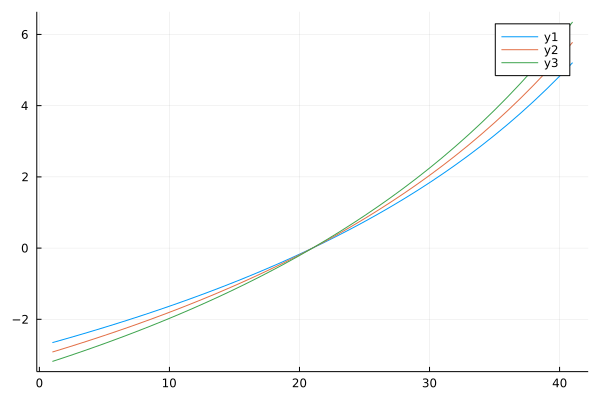

In [29]:
# plot(log.(sum.(pred_R[:,:,end])))
plot(log.(R_rel))

# Validation
Next we look at how this compares to real simulations over 100 randomly generated communties.

In [30]:
Random.seed!(1)

Nrep = 100
Nsp = 50
C0 = fill(0.01, Nsp)
#set up result arrays
real_R = Array{Any,4}(undef,length(tsave),length(ua_vec), Nrep, length(T_vec))

pred_E = Array{Any,3}(undef,length(tsave),length(ua_vec), Nrep)
real_E = Array{Any,3}(undef,length(tsave),length(ua_vec), Nrep)

for rep = 1:Nrep
    
    R = fill(1.0,Nsp) .+ randn(Nsp)./10
    r = fill(1.0,Nsp) .+ randn(Nsp)./10
    
    print(rep)
    #set up T-dependent variables
    Er,ER = abs.(0.6 .+ randn(Nsp)/10) , abs.(0.6 .+ randn(Nsp)/10)
    r_Temp = [boltz.(r,Er,T) for T = ΔT_vec]
    R_Temp = [boltz.(R,ER,T) for T = ΔT_vec]
    
    a = [ x/(Nsp-1) .+ randn(Nsp,Nsp) ./ Nsp for x = ua_vec]
    [a[i][j,j] = -10 for i = eachindex(a), j = 1:Nsp]

    dr = dboltz.(r,Er,0.0)
    dur = mean(dr)

    for int = eachindex(ua_vec)
        for T = eachindex(T_vec)
            
            p_temp = params(r_Temp[T],R_Temp[T],a[int],Nsp)
            prob = ODEProblem(dC!, C0, tspan, p_temp)
            sol = solve(prob , AutoTsit5(Rosenbrock23()), saveat = tsave)
            map(x -> x .* R_Temp[T], sol.u)
            real_R[:,int,rep,T] .= map(x -> x .* R_Temp[T], sol.u)

            for t = eachindex(tsave)
                pred_C = exp.(C_log_func.(C0, aii, r_Temp[T] ,tsave[t], Nsp * ua_vec[int] / (Nsp-1), mean(r_Temp[T]), uC0))
                E_pred = E_func.(C0,aii,tsave[t],Nsp * ua_vec[int] / (Nsp-1),dr,dur,uC0)
                pred_E[t,int,rep] =  E_R_eco(R_Temp[T], pred_C, -ER , E_pred)
            end
        end
    end
end


123456789101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899100

In [34]:
R_to_fit = log.(sum.(real_R))[:,:,:,20:22]
T_vec_to_fit = reshape(TtoΔT.(T_vec[20:22][:,:], 15), 3, 1)

for rep = 1:Nrep
    for int = eachindex(ua_vec)
        for t = eachindex(tsave)
            fit = lm(T_vec_to_fit, R_to_fit[t,int,rep,:])
            real_E[t,int,rep] = coef(fit)[1]
        end
    end
end

In [35]:
real_E_mean = mean(real_E,dims=3)[:,:,1]
real_E_upper = real_E_mean .- mapslices(x -> quantile(x,0.05),real_E, dims = 3)[:,:,1]
real_E_lower = abs.(real_E_mean .- mapslices(x -> quantile(x,0.95),real_E, dims = 3)[:,:,1])

pred_E_mean = mean(pred_E,dims=3)[:,:,1]
pred_E_upper = pred_E_mean .- mapslices(x -> quantile(x,0.05),pred_E, dims = 3)[:,:,1]
pred_E_lower = abs.(pred_E_mean .- mapslices(x -> quantile(x,0.95),pred_E, dims = 3))[:,:,1];

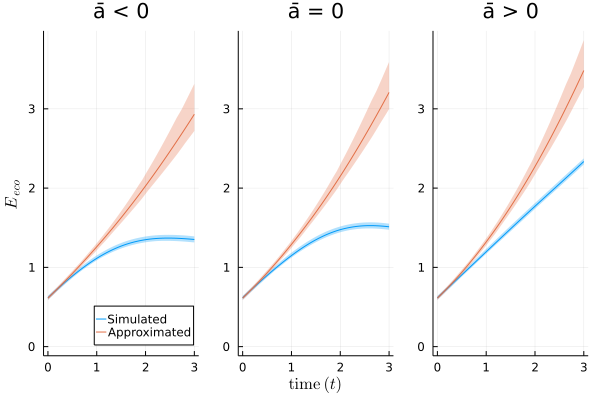

In [65]:
p = [plot(tsave, -real_E_mean[:,i], ribbon = (real_E_lower, real_E_upper), fillalpha =0.3,  legend = false, label = "Simulated") for i = 1:3]
[plot!(p[i], tsave, -pred_E_mean[:,i], ribbon = (pred_E_lower, pred_E_upper),fillalpha =0.3, legend = false, label = "Approximated") for i = 1:3]


title!(p[1],"ā < 0")
title!(p[2],"ā = 0")
title!(p[3],"ā > 0")

plot!(p[1],[0],[0],legend = :bottomright, label = "")
xlabel!(p[2],L"\mathrm{time} \ (t)")
ylabel!(p[1],L"E_{eco}")

p_E_approx_t = plot(p..., layout = (1,3), link = :y)

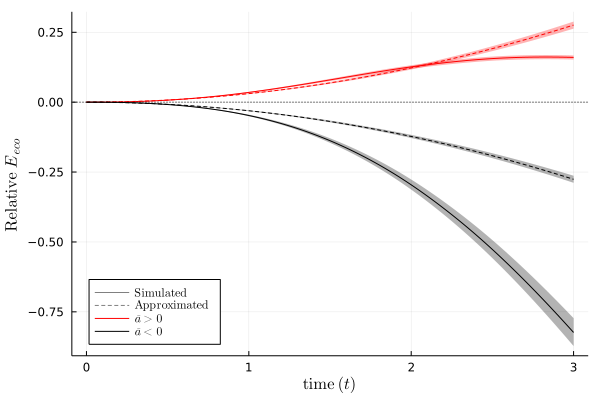

In [63]:
#create differnce arrays
facil_diff = Array{Float64,3}(undef,length(tsave),Nrep,2)
comp_diff = Array{Float64,3}(undef,length(tsave),Nrep,2)

#calculate diff in facil (real then predicted)
facil_diff[:,:,1] .= real_E[:,1,:] .- real_E[:,2,:]
facil_diff[:,:,2] .= pred_E[:,1,:] .- pred_E[:,2,:]
#calculate diff in comp
comp_diff[:,:,1] .= real_E[:,3,:] .- real_E[:,2,:]
comp_diff[:,:,2] .= pred_E[:,3,:] .- pred_E[:,2,:]

#take average across replicates
mean_diff_facil = mean(facil_diff, dims = 2)[:,1,:]
mean_diff_comp = mean(comp_diff, dims = 2)[:,1,:]
#calculate comp quantiles
diff_comp_u = mean_diff_comp .- mapslices(x -> quantile(x,0.05), comp_diff, dims = 2)[:,1,:]
diff_comp_l = abs.(mean_diff_comp .- mapslices(x -> quantile(x,0.95), comp_diff, dims = 2)[:,1,:])
#calculate facil quantiles
diff_facil_u = mean_diff_facil .- mapslices(x -> quantile(x,0.05), facil_diff, dims = 2)[:,1,:]
diff_facil_l = abs.(mean_diff_facil .- mapslices(x -> quantile(x,0.95), facil_diff, dims = 2)[:,1,:])

#plotting 
#labels
color_lab = [L"\bar{a} > 0" L"\bar{a} < 0"]
style_lab = [L"\mathrm{Simulated}" L"\mathrm{Approximated}"]
#plot
p_ΔE = plot(tsave, mean_diff_facil, ribbon = (diff_facil_l,diff_facil_u),fillalpha = 0.3, color = "red", linestyle = [:solid :dash] , legend = :bottomleft, label = "")
plot!(tsave, mean_diff_comp, ribbon = (diff_comp_l, diff_comp_u), fillalpha =0.3,  color = "black", linestyle = [:solid :dash], label = "")
#legends
plot!([0 0],[0 0],color = ["grey"],linestyle = [:solid :dash],label = style_lab)
plot!([0 0],[0 0],color = ["red" "black"],label = color_lab)
#0 - line
hline!([0.0], color = "black", linestyle = :dot, label = "")
xlabel!(L"\mathrm{time} \ (t)")
ylabel!(L"\mathrm{Relative} \ E_{eco}")

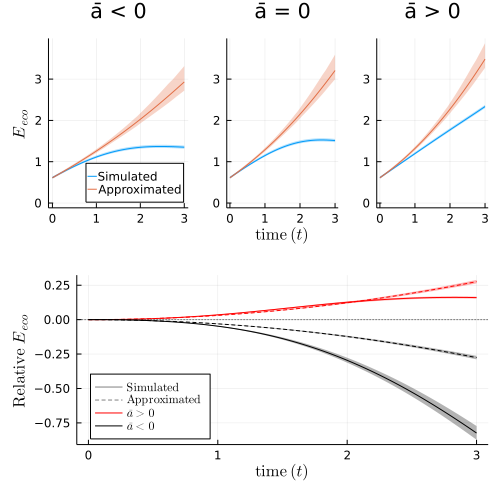

In [68]:
p_final = plot(p_E_approx_t, p_ΔE, layout = (2,1), size = (500, 500))

# Plots.annotate!(p_final, 1, 1, "a")

# annotate!(p_final, subplot = 1, -0.8,3,"a")
# annotate!(p_final, subplot = 4, -0.54,0.3,"b")

In [69]:
savefig(p_final, "../plots/S6_Eapp_time.pdf")

# Changes in system size


In [70]:
#Changes in system size
#Look at the error at t=1 for different system sizes

Random.seed!(1)
Nrep = 10
Nsp = 25


#set up result arrays
real_R = Array{Any,4}(undef,Nsp,length(ua_vec), Nrep, length(T_vec))
pred_E = Array{Any,3}(undef,Nsp,length(ua_vec), Nrep)
real_E = Array{Any,3}(undef,Nsp,length(ua_vec), Nrep)

for N = 1:Nsp
    print(N)
    C0 = fill(0.01, N)
    for rep = 1:Nrep
        Random.seed!(rep)
        R = fill(1.0,N) .+ randn(N)./10
        r = fill(1.0,N) .+ randn(N)./10

        #set up T-dependent variables
        Er,ER = abs.(0.6 .+ randn(N)/10) , abs.(0.6 .+ randn(N)/10)
        r_Temp = [boltz.(r,Er,T) for T = ΔT_vec]
        R_Temp = [boltz.(R,ER,T) for T = ΔT_vec]

        a = [ x/(Nsp-1) .+ randn(N,N) ./ N for x = ua_vec]
        [a[i][j,j] = -10 for i = eachindex(a), j = 1:N]

        dr = dboltz.(r,Er,0.0)
        dur = mean(dr)

        for int = eachindex(ua_vec)
            for T = eachindex(T_vec)
                p_temp = params(r_Temp[T],R_Temp[T],a[int],N)
                prob = ODEProblem(dC!, C0, tspan, p_temp)
                sol = solve(prob , AutoTsit5(Rosenbrock23()), saveat = tsave)
                
                real_R[N,int,rep,T] = sol(1.0)
                pred_C = exp.(C_log_func.(C0, aii, r_Temp[T] ,1.0, N * ua_vec[int] / (Nsp - 1), mean(r_Temp[T]), uC0))
                E_pred = E_func.(C0,aii,1.0, N * ua_vec[int] / (Nsp - 1),dr,dur,uC0)
                pred_E[N,int,rep] =  E_R_eco(R_Temp[T], pred_C, -ER , E_pred)
            end
        end
    end
end


12345678910111213141516171819202122232425

In [71]:
R_to_fit = log.(sum.(real_R))[:,:,:,20:22]
T_vec_to_fit = reshape(TtoΔT.(T_vec[20:22][:,:], 15), 3, 1)

for rep = 1:Nrep
    for int = eachindex(ua_vec)
        for N = 1:Nsp
            fit = lm(T_vec_to_fit, R_to_fit[N,int,rep,:])
            real_E[N,int,rep] = coef(fit)[1]
        end
    end
end

In [72]:
real_E_mean = mean(real_E,dims = 3)[:,:,1]
real_E_upper = real_E_mean .- mapslices(x -> quantile(x,0.05),real_E, dims = 3)[:,:,1]
real_E_lower = abs.(real_E_mean .- mapslices(x -> quantile(x,0.95),real_E, dims = 3)[:,:,1])

pred_E_mean = mean(pred_E,dims=3)[:,:,1]
pred_E_upper = pred_E_mean .- mapslices(x -> quantile(x,0.05),pred_E, dims = 3)[:,:,1]
pred_E_lower = abs.(pred_E_mean .- mapslices(x -> quantile(x,0.95),pred_E, dims = 3))[:,:,1];

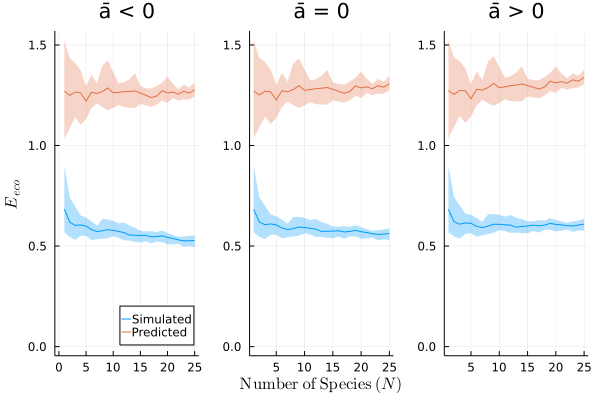

In [74]:
p = [plot(1:Nsp, -real_E_mean[:,i], ribbon = (real_E_lower, real_E_upper), fillalpha =0.3,  legend = false, label = "Simulated") for i = 1:3]
[plot!(p[i], 1:Nsp, -pred_E_mean[:,i], ribbon = (pred_E_lower, pred_E_upper),fillalpha =0.3, legend = false, label = "Predicted") for i = 1:3]

title!(p[1],"ā < 0")
title!(p[2],"ā = 0")
title!(p[3],"ā > 0")

plot!(p[1],[0],[0],legend = :bottomright, label = "")
xlabel!(p[2],L"\mathrm{Number \ of \ Species} \ (N)")
ylabel!(p[1],L"E_{eco}")

p_E_approx_t = plot(p..., layout = (1,3), link = :y)

In [75]:
#create differnce arrays
facil_diff = Array{Float64,3}(undef,Nsp,Nrep,2)
comp_diff = Array{Float64,3}(undef,Nsp,Nrep,2)

#calculate diff in facil (real then predicted)
facil_diff[:,:,1] .= real_E[:,1,:] .- real_E[:,2,:]
facil_diff[:,:,2] .= pred_E[:,1,:] .- pred_E[:,2,:]
#calculate diff in comp
comp_diff[:,:,1] .= real_E[:,3,:] .- real_E[:,2,:]
comp_diff[:,:,2] .= pred_E[:,3,:] .- pred_E[:,2,:]

#take average across replicates
mean_diff_facil = mean(facil_diff, dims = 2)[:,1,:]
mean_diff_comp = mean(comp_diff, dims = 2)[:,1,:]

#calculate comp quantiles
diff_comp_u = mean_diff_comp .- mapslices(x -> quantile(x,0.05), comp_diff, dims = 2)[:,1,:]
diff_comp_l = abs.(mean_diff_comp .- mapslices(x -> quantile(x,0.95), comp_diff, dims = 2)[:,1,:])
#calculate facil quantiles
diff_facil_u = mean_diff_facil .- mapslices(x -> quantile(x,0.05), facil_diff, dims = 2)[:,1,:]
diff_facil_l = abs.(mean_diff_facil .- mapslices(x -> quantile(x,0.95), facil_diff, dims = 2)[:,1,:]);


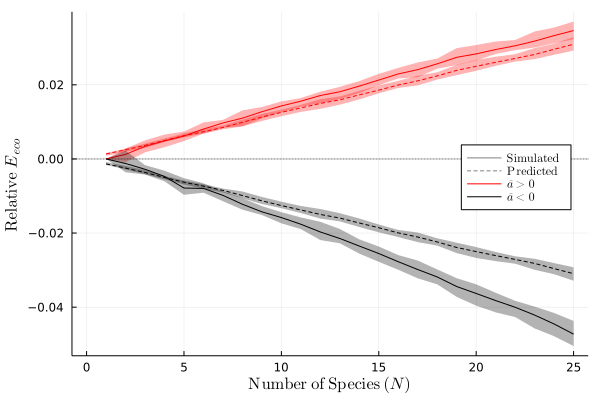

In [76]:
#plotting 
#labels
color_lab = [L"\bar{a} > 0" L"\bar{a} < 0"]
style_lab = [L"\mathrm{Simulated}" L"\mathrm{Predicted}"]
#plot
p_ΔE_N = plot(1:Nsp, mean_diff_facil, ribbon = (diff_facil_l,diff_facil_u),fillalpha = 0.3, color = "red", linestyle = [:solid :dash] , legend = :right, label = "")
plot!(1:Nsp, mean_diff_comp, ribbon = (diff_comp_l, diff_comp_u), fillalpha =0.3,  color = "black", linestyle = [:solid :dash], label = "")
#legends
plot!([0 0],[0 0],color = ["grey"],linestyle = [:solid :dash],label = style_lab)
plot!([0 0],[0 0],color = ["red" "black"],label = color_lab)
#0 - line
hline!([0.0], color = "black", linestyle = :dot, label = "")
xlabel!(L"\mathrm{Number \ of \ Species} \ (N)")
ylabel!(L"\mathrm{Relative} \ E_{eco}")

In [77]:
savefig(p_ΔE_N, "../plots/S7_meanfield_N.pdf")

# Intransivity

In [78]:
function intrans_community(ā, loop_max, B, N)
    @assert loop_max ≤ N

    a = (randn(N,N) ./ 10 ) .+ ā
    #add intraspecific interactions
    [a[i,i] = -1.0 for i = 1:N]

    #get indicies
    comb = combinations(1:N,loop_max) |> collect
    intrans_ind_1 = [[comb[1][i],circshift(comb[1],1)[i]] for i = 1:loop_max]
    intrans_ind_2 = [[circshift(comb[1],1)[i],comb[1][i]] for i = 1:loop_max]

    #add intransitive interactions
    a_non_int = 0.0
    a_int = 0.0
    for i = 1:N
        for j = 1:N
            if [i,j] ∈ intrans_ind_1
                a[i,j] = B
                a_int += B
            elseif [i,j] ∈ intrans_ind_2
                a[i,j] = 0.0
            elseif i ≠ j
                a_non_int += a[i,j]
            end
        end
    end

    #target a
    N_tot = (N^2) - N
    N_int = N_tot - 2*loop_max
    N_n_int = N_tot - N_int

    a_target = (N_tot) * ā
    a_actual = a_non_int + a_int
    a_diff = a_target - a_actual 

    A = a_diff / N_n_int

    for i = 1:N
        for j = 1:N
            if ([i,j] ∉ intrans_ind_1) & ([i,j] ∉ intrans_ind_2) & (i≠j)
                a[i,j] += A
            end
        end
    end

    return(params(rand(N),rand(N),a, N))
end

intrans_community (generic function with 1 method)

In [79]:
#Changes in intrans size
#Look at the error at t=1 for different system sizes

Random.seed!(1)
N_loop = 5
N_B = 20
B_vec = range(0.0, -2.0, length = N_B)
Nrep = 10
Nsp = 5

#biomass
C0 = fill(0.01, Nsp)

#set up result arrays
real_R = Array{Any,5}(undef,N_loop,N_B,length(ua_vec), Nrep, length(T_vec))
pred_E = Array{Any,4}(undef,N_loop,N_B,length(ua_vec), Nrep)
real_E = Array{Any,4}(undef,N_loop,N_B,length(ua_vec), Nrep)

for int = eachindex(ua_vec)
    for loop = 1:N_loop
        for B = 1:N_B
            for rep = 1:Nrep
                Random.seed!(rep)

                param_ = intrans_community(ua_vec[int] / (Nsp-1), loop, B_vec[B], Nsp)
                
                R = param_.R
                r = param_.r
                
                #set up T-dependent variables
                Er,ER = abs.(0.6 .+ randn(Nsp) / 10) , abs.(0.6 .+ randn(Nsp) / 10)
                r_Temp = [boltz.(r,Er,T) for T = ΔT_vec]
                R_Temp = [boltz.(R,ER,T) for T = ΔT_vec]
                
                dr = dboltz.(r,Er,0.0)
                dur = mean(dr)
                
                for T = eachindex(T_vec)
                    p_temp = params(r_Temp[T],R_Temp[T],param_.a,Nsp)
                    prob = ODEProblem(dC!, C0, (0.0,1.0), p_temp)
                    sol = solve(prob , AutoTsit5(Rosenbrock23()), saveat = tsave)
                    real_R[loop, B , int, rep, T] = sol(1.0)
                   
                    pred_C = exp.(C_log_func.(C0, aii, r_Temp[T] ,1.0, Nsp*ua_vec[int]/(Nsp-1), mean(r_Temp[T]), uC0))
                    E_pred = E_func.(C0, aii, 1.0,  Nsp*ua_vec[int]/(Nsp-1), dr, dur, uC0)
                    pred_E[loop, B , int, rep] =  E_R_eco(R_Temp[T], pred_C, -ER , E_pred)
                end
            end
        end
    end
end

In [80]:
R_to_fit = log.(sum.(real_R))[:,:,:,:,20:22]
T_vec_to_fit = reshape(TtoΔT.(T_vec[20:22][:,:], 15), 3, 1)

for rep = 1:Nrep
    for int = eachindex(ua_vec)
        for loop = 1:Nsp
            for B = 1:N_B
                fit = lm(T_vec_to_fit, R_to_fit[loop,B,int,rep,:])
                real_E[loop,B,int,rep] = coef(fit)[1]
            end
        end
    end
end

In [81]:
#create differnce arrays
facil_diff = Array{Float64,4}(undef,N_loop,N_B,Nrep,2)
comp_diff = Array{Float64,4}(undef,N_loop,N_B,Nrep,2)

# #calculate diff in facil (real then predicted)
facil_diff[:,:,:,1] .= real_E[:,:,1,:] .- real_E[:,:,2,:]
facil_diff[:,:,:,2] .= pred_E[:,:,1,:] .- pred_E[:,:,2,:]
#calculate diff in comp
comp_diff[:,:,:,1] .= real_E[:,:,3,:] .- real_E[:,:,2,:]
comp_diff[:,:,:,2] .= pred_E[:,:,3,:] .- pred_E[:,:,2,:]

# #take average across replicates
mean_diff_facil = mean(facil_diff, dims = 3)[:,:,1,:]
mean_diff_comp = mean(comp_diff, dims = 3)[:,:,1,:]

# #calculate comp quantiles
diff_comp_u = mean_diff_comp .- mapslices(x -> quantile(x,0.05), comp_diff, dims = 3)[:,:,1,:]
diff_comp_l = abs.(mean_diff_comp .- mapslices(x -> quantile(x,0.95), comp_diff, dims = 3)[:,:,1,:])

# #calculate facil quantiles
diff_facil_u = mean_diff_facil .- mapslices(x -> quantile(x,0.05), facil_diff, dims = 3)[:,:,1,:]
diff_facil_l = abs.(mean_diff_facil .- mapslices(x -> quantile(x,0.95), facil_diff, dims = 3)[:,:,1,:]);


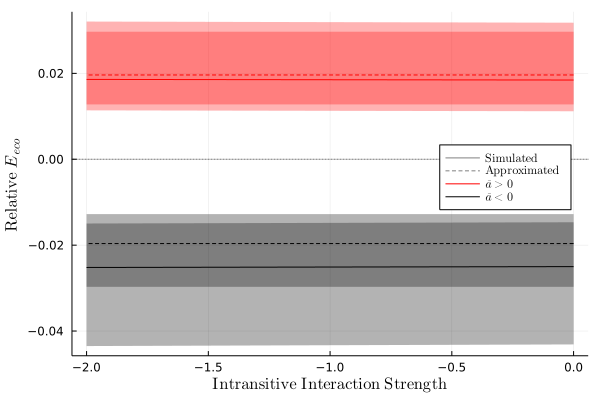

In [83]:
nl = 5
#plotting 
#labels
color_lab = [L"\bar{a} > 0" L"\bar{a} < 0"]
style_lab = [L"\mathrm{Simulated}" L"\mathrm{Approximated}"]
#plot
p_ΔE_intrans = plot(B_vec, mean_diff_facil[nl,:,:], ribbon = (diff_facil_l[nl,:,:], diff_facil_u[nl,:,:]),fillalpha = 0.3, color = "red", linestyle = [:solid :dash] , legend = :right, label = "")
plot!(B_vec, mean_diff_comp[nl,:,:], ribbon = (diff_comp_l[nl,:,:], diff_comp_u[nl,:,:]), fillalpha =0.3,  color = "black", linestyle = [:solid :dash], label = "")
# #legends
plot!([0 0],[0 0],color = ["grey"],linestyle = [:solid :dash],label = style_lab)
plot!([0 0],[0 0],color = ["red" "black"],label = color_lab)
#0 - line
hline!([0.0], color = "black", linestyle = :dot, label = "")
xlabel!(L"\mathrm{Intransitive \ Interaction \ Strength}")
ylabel!(L"\mathrm{Relative} \ E_{eco}")

In [84]:
savefig(p_ΔE_intrans, "../plots/S1_meanfield_intra.pdf")

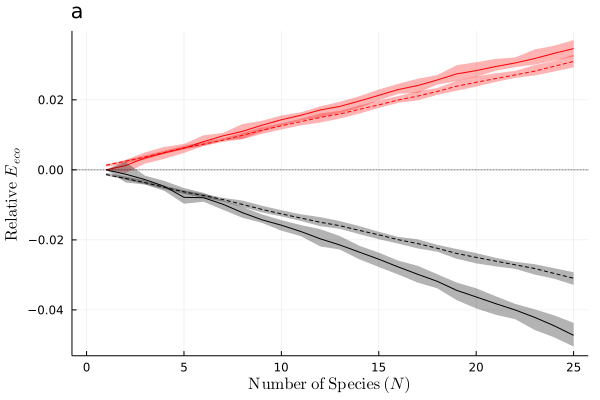

In [87]:
p_ΔE_N = plot(p_ΔE_N, legend = false, title = "a", titleloc = :left)
p_ΔE_intrans = plot(p_ΔE_intrans, title = "b", titleloc = :left)

xlabel!(p_ΔE_N, L"\mathrm{Number \ of \ Species} \ (N)")


# p_ΔE_comb = plot(p_ΔE_N,p_ΔE_intrans, link = :y, layout = (2,1), size = (500,500))

# savefig(p_ΔE_comb, "../plots/FigS4_meanfield_test.pdf")